In [2]:
!pip3 install tensorflow matplotlib tensorflow-datasets ipywidgets


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: C:\Users\jazmi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [21]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [23]:
ds = tfds.load('fashion_mnist', split='train')

In [26]:
ds.as_numpy_iterator().next()['label']

2

In [37]:
import numpy as np
dataiterator = ds.as_numpy_iterator()
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

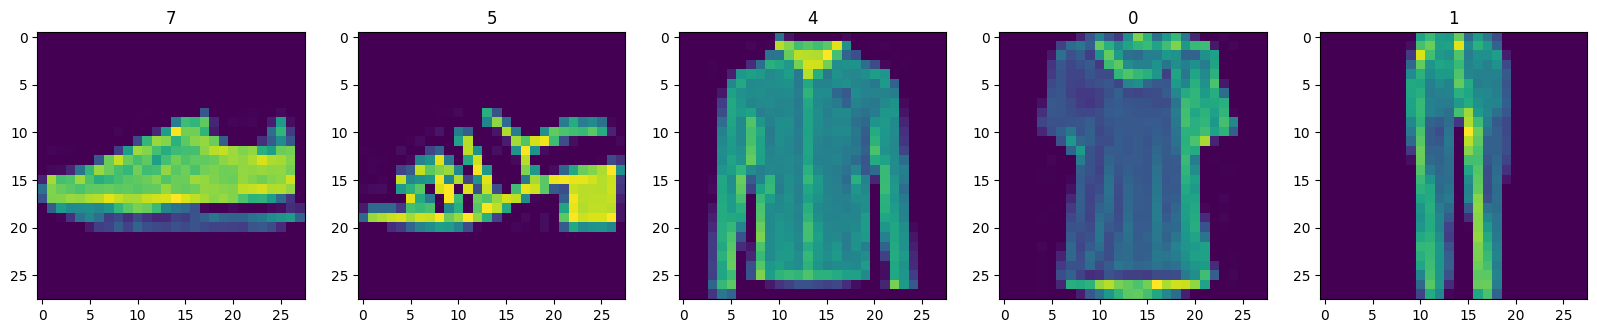

In [34]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx in range(5): 
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [ ]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [ ]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images) 
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)